In [1]:
from pathlib import Path

from netaddr import IPNetwork, IPRange, IPAddress
import pandas

jpnic = []
for l in pandas.read_csv('data/jpnic-ipv4_20200121.csv').itertuples():
    jpnic.extend(IPRange(l.start, l.end).cidrs())
iana = pandas.read_csv('data/iana-ipv4_20200120.csv')
apnic = [IPNetwork(_.replace('/', '.0.0.0/')) for _ in iana[iana['Designation'] == 'APNIC']['Prefix']]
ipaddr = [IPAddress(_) for _ in Path('tests/test_address').read_text().splitlines()]

In [2]:
ipaddr[:10]

[IPAddress('46.51.244.179'),
 IPAddress('18.179.185.98'),
 IPAddress('99.78.189.55'),
 IPAddress('15.177.77.107'),
 IPAddress('52.95.111.6'),
 IPAddress('103.246.150.119'),
 IPAddress('52.94.8.21'),
 IPAddress('13.248.31.163'),
 IPAddress('13.124.247.73'),
 IPAddress('150.222.77.76')]

In [3]:
import ClustIPy

cidrs = ClustIPy.agglomerative(ipaddr, 30)
cidrs[:10]

[IPNetwork('3.34.48.18/32'),
 IPNetwork('3.112.0.0/14'),
 IPNetwork('13.112.0.0/14'),
 IPNetwork('13.124.0.0/15'),
 IPNetwork('13.208.0.0/15'),
 IPNetwork('13.224.0.0/11'),
 IPNetwork('15.164.128.0/17'),
 IPNetwork('15.177.76.0/22'),
 IPNetwork('15.193.1.0/24'),
 IPNetwork('18.176.0.0/13')]

In [4]:
import numpy as np
from netaddr import IPNetwork
from matplotlib.pyplot import imsave


coords = np.load('data/hilvert_p12_n2.npz')['arr_0']
img = np.zeros((4096, 4096))

for net in apnic:
    try:
        for s in net.subnet(24):
            pos = int(int(s.ip)/256)
            x, y = coords[pos, :]
            img[x, y] = 32
    except:
        pass

for net in jpnic:
    try:
        for s in net.subnet(24):
            pos = int(int(s.ip)/256)
            x, y = coords[pos, :]
            img[x, y] = 64
    except:
        pass

for net in cidrs:
    try:
        for s in net.subnet(24):
            pos = int(int(s.ip)/256)
            x, y = coords[pos, :]
            img[x, y] = 128 + 64
    except:
        pass

for ip in ipaddr:
    pos = int(int(IPNetwork(f'{ip}/24').network)/256)
    x, y = coords[pos, :]
    img[x, y] = 255

imsave('viz_aws_gip.pdf', img)

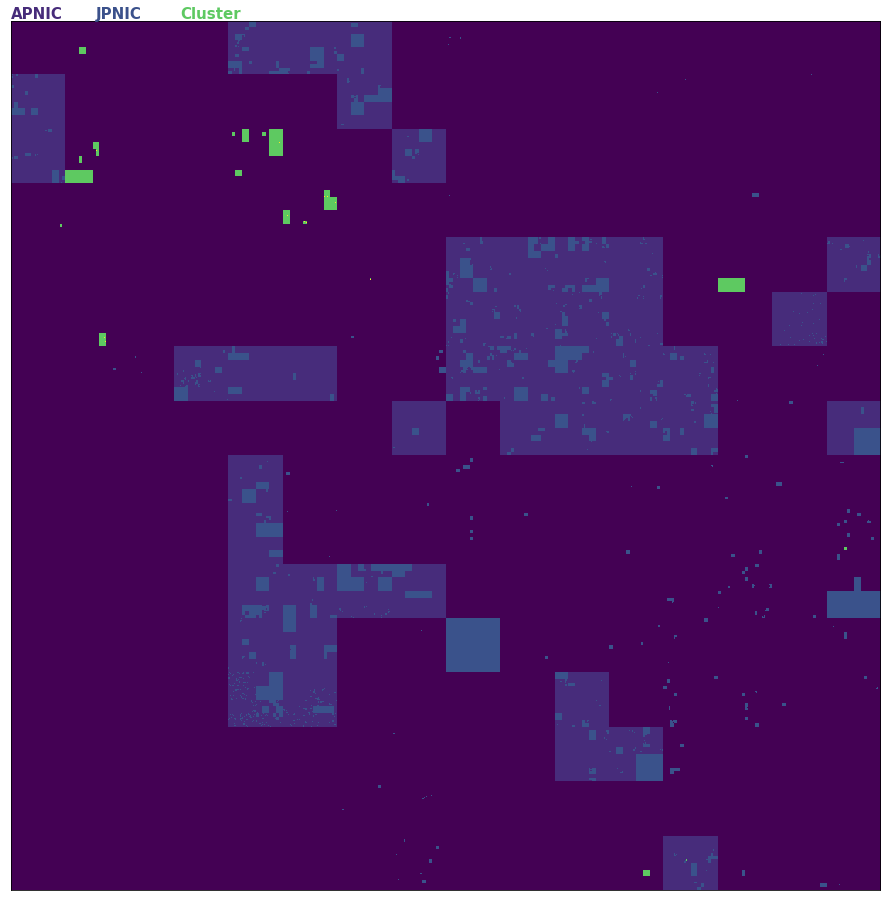

In [5]:
from matplotlib.pyplot import subplots, get_cmap

fig, ax = subplots(figsize=(16, 16))
ax.set_xticks([])
ax.set_yticks([])
ax.text(0, -10, 'APNIC', color=get_cmap('viridis')(31), weight='heavy', size=15)
ax.text(400, -10, 'JPNIC', color=get_cmap('viridis')(63), weight='heavy', size=15)
ax.text(800, -10, 'Cluster', color=get_cmap('viridis')(192), weight='heavy', size=15)
ax.imshow(img)